### <ins>Mini-Project: Amsterdam House Price Analysis with Decision Tree Variations and SGD Linear Regression</ins><br>
<i> -This notebook is to see as personal exercise-

Here we work with the data set "Amsterdam House Price Prediction" <i>from Kaggle (https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction).</i><br>
The overarching goal is to create a model that <b>predicts the market price of houses</b> based on the information we get from the aforementioned dataset. 
<br>
<br>The dataset contains:
<ul>
<li>address</li>
<li><b>zip-code</b></li>
<li><b>price</b></li>
<li><b>space</b></li>
<li><b>room count</b></li>
<li>lat/lon coordinates</li></ul>
<br>
of <b>924 houses</b> within the amsterdam region. <b>Price</b> will be <b>our target</b> to predict and we will focus on the <b>zip-code, space and room count</b> as <b>our predictors</b><br>
<br>
Since Price is an continues numerical parameter we will use regression models for our predictions. If these wont provide reasonable results we will think about transforming the target price into a categorical parameter which might improve predictions.
<br>
<br>
<i>.... OK! lets get started</i>
<br>
<br>
First we load all packages we will need:

In [36]:
# Loading all Packages
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import plotly.express as px
import scipy as spy
import seaborn as sns
import random

# ML Packages
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

We load the .csv (downloaded from Kaggle) to a dataframe and check the data formats and missing values

In [37]:
# Loading dataframe
data = pd.read_csv(".\HousingPrices-Amsterdam-August-2021.csv")

The first look shows us that we have 3 features that are potential good estimators: Rooms, Area (aka house size in m²) and the Zip Code (specifying the location of the house)

In [38]:
# First look at data format and check for missing values
display(data.head(5))
display(data.info())
if 0 in data == True:
    print("Columns contain Zeroes")
else:
    print("Columns contain NO Zeroes")

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  924 non-null    int64  
 1   Address     924 non-null    object 
 2   Zip         924 non-null    object 
 3   Price       920 non-null    float64
 4   Area        924 non-null    int64  
 5   Room        924 non-null    int64  
 6   Lon         924 non-null    float64
 7   Lat         924 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 57.9+ KB


None

Columns contain NO Zeroes


We see that, except for the first column, all columns are sensical with representative names. Since "Unnamed: 0" appears to be just an index column which we will check by confirming that the values continuously increase by 1 <br>
<br>
Also we see that only Price is missing values. Since those are only 4 we will exclude the rows entirely 

Mean of 'Unnamed: 0':  462.5
Mean of a continuous number series of 'Unnamed: 0' length:  462.5
The slope is:  1.0


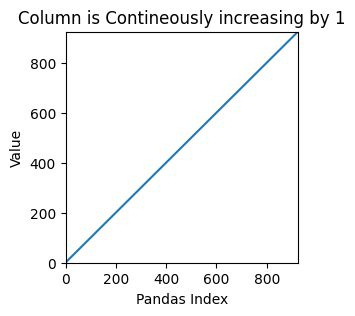

In [39]:
# Calculate mean of Unnamed and compare to mean of simple continuous series with increase of 1 - indication 1 for Unnamed = Index
print("Mean of 'Unnamed: 0': ",data["Unnamed: 0"].mean())
print("Mean of a continuous number series of 'Unnamed: 0' length: ", sum(range(data["Unnamed: 0"].iat[0],data["Unnamed: 0"].iat[-1]+1))/len(data["Unnamed: 0"]))

# Calculate slope of Unnamed showing slope is equal 1 - indication 2 for Unnamed = Index
test_slope = spy.stats.linregress(data["Unnamed: 0"],data.index)[0]
print("The slope is: ", test_slope)

# Plotting Unnamed to visualize continuity and slope of Unnamed 
plt.figure(figsize=(3,3))
sns.lineplot(data["Unnamed: 0"])
plt.title("Column is Contineously increasing by 1")
plt.xlabel("Pandas Index")
plt.xlim(0,925)
plt.ylabel("Value")
plt.ylim(0,925)
plt.show()

# Renaming Unnamed column and drop NaN rows
data = data.rename(columns={"Unnamed: 0":"index"})
data = data.drop(data.loc[data["Price"].isna() == True,"Price"].index)


Since the mean of "Unnamed: 0" is equal to the mean of a simple continuous number series counting from 1 to 925 and the line plot shows straight line with a slop of 1 we conclude that this column is indeed just an index column. The column is therefore renamed to "index"

Checking if the size of the house (area) and room count (room) correlate with the house price shows that both can serve as relatively good estimators (room r=0.62; area r=0.83 <br>
<br>
First we look at a quick correlation matrix and additionally we look at the data with a scatter plot

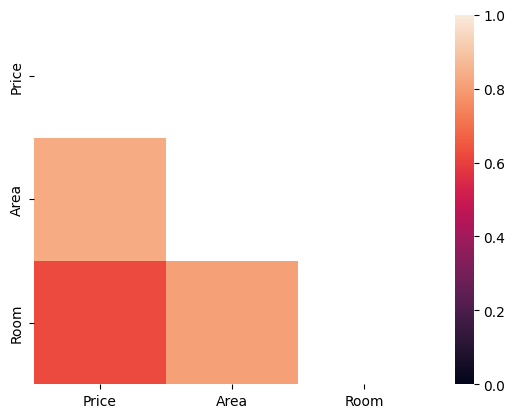

In [40]:
#first look at correlations
mask = np.array([[1,1,1],[0,1,1],[0,0,1]])
sns.heatmap(data[["Price","Area","Room"]].corr(method="pearson"), vmin=0, vmax=1, mask=mask)
plt.show()

r value for Room vs Price:  0.6234480047123797
r value for Area vs Price:  0.8350901785664225


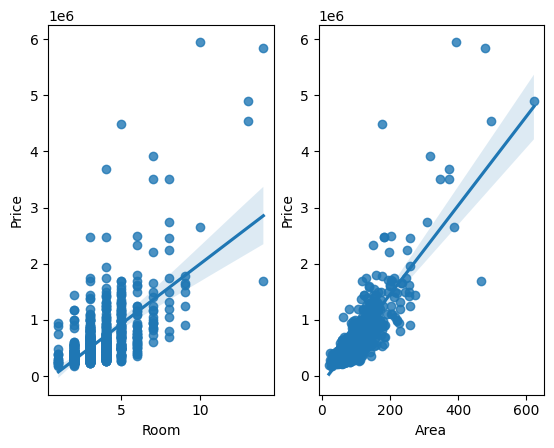

In [41]:
fig2, axs = plt.subplots(ncols=2)
sns.regplot(data=data,x="Room",y="Price", ax=axs[0])
sns.regplot(data=data,x="Area",y="Price", ax=axs[1])
print("r value for Room vs Price: ", spy.stats.linregress(data["Room"], data["Price"])[2])
print("r value for Area vs Price: ", spy.stats.linregress(data["Area"], data["Price"])[2])
plt.show()

Lets have a look at the zip code data. It is a very appropriate guess that the zip code is a good estimator for the price of a house. This is usally the case of bigger cities like amsterdam is. However when we look up the how zip codes are constructed for the netherlands we see that the code specifies an area down to a street. This is way to specific for the data we have available here. Using this zip codes straight away would dilute the data set, meaning we get for many zip codes only one or two houses to work with. Therefor we first decode the zip to its first 4 numbers which specify a specific area within the city (70 areas).

In [42]:
data["Region"] = data["Zip"].str[0:4].astype(int)
data["Price"] = data["Price"].astype(float)
data["Area"] = data["Area"].astype(float)
data["Room"] = data["Room"].astype(int)

As expected simply plotting a bar plot representing each region clearly shows that some regions sell for more.<br>
<br>
<i>Note: Since we are interested in the mean we plot the SEM)</i>

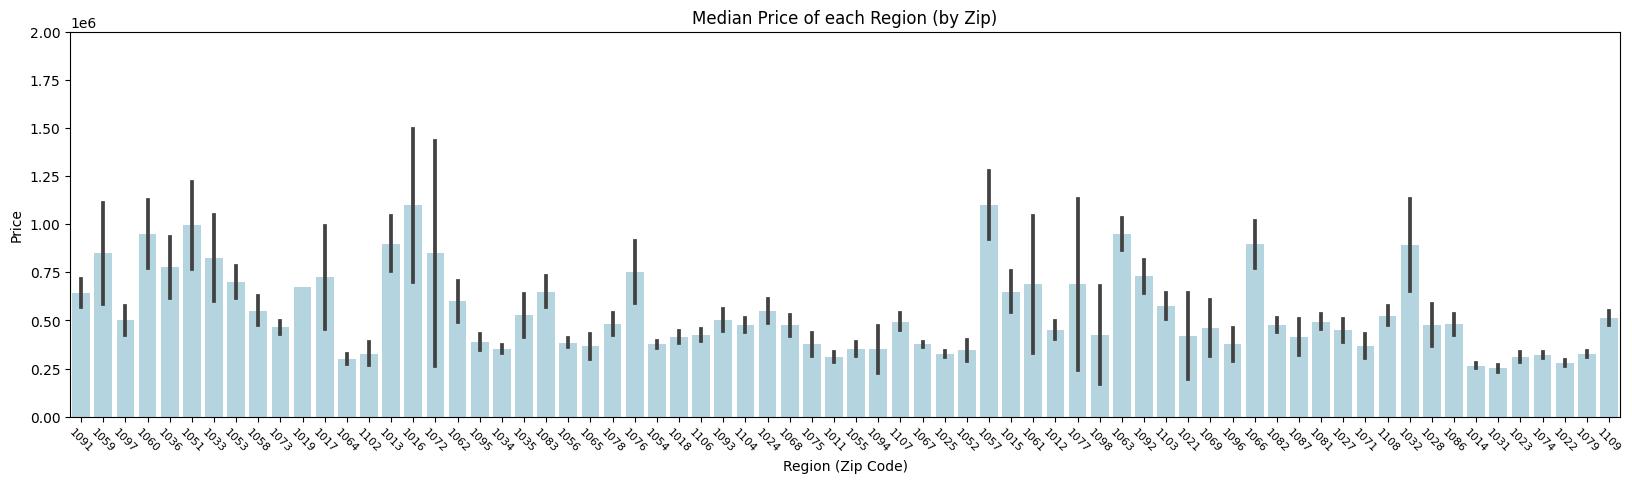

In [102]:
fig3, ax = plt.subplots(figsize=(20,5))
fig3 = sns.barplot(data=data,x="Region",y="Price", estimator="median", errorbar="se", color="lightblue")#, order= Price_columns.columns.sort_values())
fig3.set_xticklabels(labels=data["Region"].unique() ,fontdict={"fontsize":"8","rotation":"-45"})
fig3.set_title("Median Price of each Region (by Zip)")
fig3.set_ylabel("Price")
fig3.set_xlabel("Region (Zip Code)")
fig3.set(ylim=(0,(2*10**6)))
plt.show()

To check if there is truly a significant difference within the regions (groups) we perform a quick simple ANOVA test<br>
We will see that the p-value is < 0.05, thus we can reject H0 and confirmed that there is a significant difference between the groups<br>
<br>
<i>Note: For that we first have to quickly transform the data into a list without NaNs so we can use the Scipy function<i>

In [47]:
Regio_Price = data[["Region","Price"]].copy()
Regio_Price["Region"] = Regio_Price["Region"].astype(str)

In [48]:
region_list = Regio_Price.Region.unique()
All_Regio_Price = []
for i in region_list:

    All_Regio_Price.append(list(Regio_Price["Price"][Regio_Price["Region"]==i]))


In [67]:
print("p-value of ANOVA test: ", spy.stats.f_oneway(*All_Regio_Price)[1])

p-value of ANOVA test:  4.63879592800892e-28


To get a better idea about the regions within amsterdam we us plotly and geojson data to project every region we use onto a map

In [13]:

geodata=json.load(open("./georef-netherlands-postcode-pc4_simple.geojson","r"))

#plotly needs specificly "id" within features so we have to copy them from properties to features
for i in geodata["features"]:
    i["id"]=i["properties"]["pc4_code"]

In [14]:
#get zip codes from geojson data
zip_list = []
for i in geodata["features"]:
    zip_list.append(i["properties"]["pc4_code"])

#check if every zip code in data set is present in geodata
for i in data["Region"].unique():
    if str(i) not in zip_list:
        print(i, "is not represented in geojson")


In [125]:
avg_data = data.groupby(["Region"]).median().reset_index()[["Region","Price"]]

In [126]:
fig2 = px.choropleth_mapbox(
    avg_data,
    locations=avg_data["Region"],
    geojson=geodata,color=avg_data["Price"],
    zoom=9.7, 
    center = {"lat": 52.356157, "lon": 4.907736},
    color_continuous_scale="matter", 
    mapbox_style="carto-positron",
    hover_data=avg_data,
    range_color=[avg_data["Price"].min(),avg_data["Price"].max()],
    width=1000,
    height=500
)

fig2.update_layout(                      
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig2.show()

NameError: name 'geodata' is not defined

When plotting the count of houses per region we realize that many regions represent less than 10 houses. Since we already established that the price in dependent on the region the house is in we will circumvent this high imbalance of data by creating "new regions" that correspond to a certain price range<br>
<br>
We will arbitrarily create five regions which should represent realistic boundaries: less > 300000, less > 600000, less > 900000, less > 1200000, more < 1200000

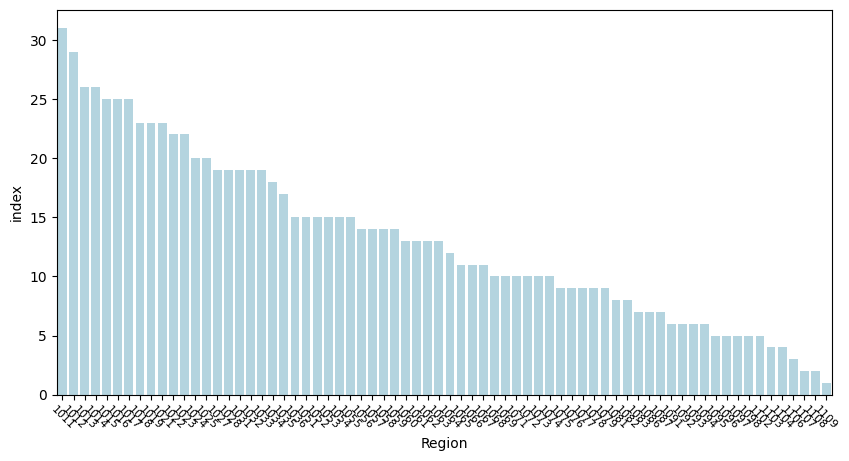

In [114]:
agg_data = data.groupby("Region").count().reset_index()
fig3 = plt.subplots(figsize=(10,5))
fig3 = sns.barplot(x=agg_data.iloc[:,0], y=agg_data.iloc[:,1], order=agg_data.sort_values(by="index", ascending=False).iloc[:,0], color="lightblue")
fig3.set_xticklabels(labels=agg_data.iloc[:,0],fontdict={"fontsize":"8","rotation":"-45"})
plt.show()

In [103]:
new_regions = ["less_0","less_300000","less_600000","less_900000","less_1200000","more_1200000"]
binned_data = data[["Price","Region","Area","Room","index"]].copy()

for i in range(len(new_regions)):
    
    if (new_regions[i].split("_")[0]) == "less":
        binned_data[new_regions[i+1]] = binned_data.loc[(binned_data["Price"] <= int(new_regions[i+1].split("_")[1])) & (binned_data["Price"] > int(new_regions[i].split("_")[1])), "Price"]
        
    elif new_regions[i].split("_")[0] == "more":
        binned_data[new_regions[i]] = binned_data.loc[(binned_data["Price"] > int(new_regions[i].split("_")[1])), "Price"]
        
    else:
        break


p-value of ANOVA test:  4.433511789529153e-224


After creating the regions and sorting the data we see that the standard deviation is relatively low (except for prices higher 1.2M). Plotting the count of houses in each regions shows a big improvement as the lowest count is now 70. However, we also see that the data is still very imbalanced. This also explains the high variation of the 1.2M region.<br>
<br>
<b>Since the data set is so small we do not have a very good angle to work on the data imbalance. Over-sampling is extremely likely to lead to over fitting. Under-sampling is also no option with this small data set. For the purpose of this exercise we will just continue with the data as is.<b>

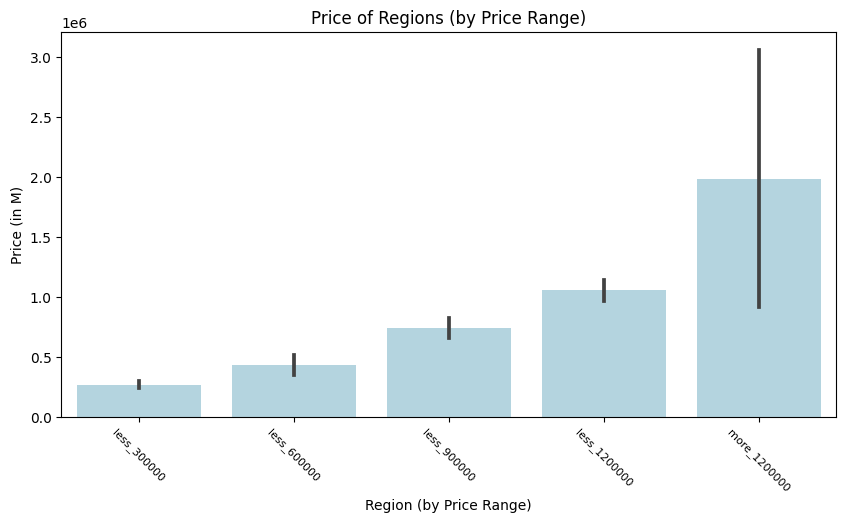

p-value of ANOVA test:  4.433511789529153e-224


In [156]:
fig4, ax = plt.subplots(figsize=(10,5))
fig4 = sns.barplot(data = binned_data.iloc[:,5:],color="lightblue", errorbar="sd")
fig4.set_xticklabels(labels=list(binned_data.iloc[:0,5:]),fontdict={"fontsize":"8","rotation":"-45"})
fig4.set_title("Price of Regions (by Price Range)")
fig4.set_ylabel("Price (in M)")
fig4.set_xlabel("Region (by Price Range)")
plt.show()


bins_for_test = []
for i in new_regions[1:]:
    bins_for_test.append(binned_data.loc[binned_data[i].notna() == True, i])

print("p-value of ANOVA test: ", spy.stats.f_oneway(*bins_for_test)[1])

In [152]:
lable_encoded_data = binned_data.drop(["index","Region"], axis=1)
lable_encoded_data[lable_encoded_data[new_regions[1:]].isna() == True] = 0
lable_encoded_data[lable_encoded_data[new_regions[1:]] != 0] = 1

In [153]:
for t,i in enumerate(new_regions[1:]):
        
    lable_encoded_data.loc[lable_encoded_data[i] == 1, [i]] += t
    
    if t > 0:
        lable_encoded_data[new_regions[1]] += lable_encoded_data[i]


lable_encoded_data[new_regions[1:]] -= 1
lable_encoded_data.drop(new_regions[2:], axis=1, inplace=True)
lable_encoded_data.rename(columns={new_regions[1] : "Regions"}, inplace=True)


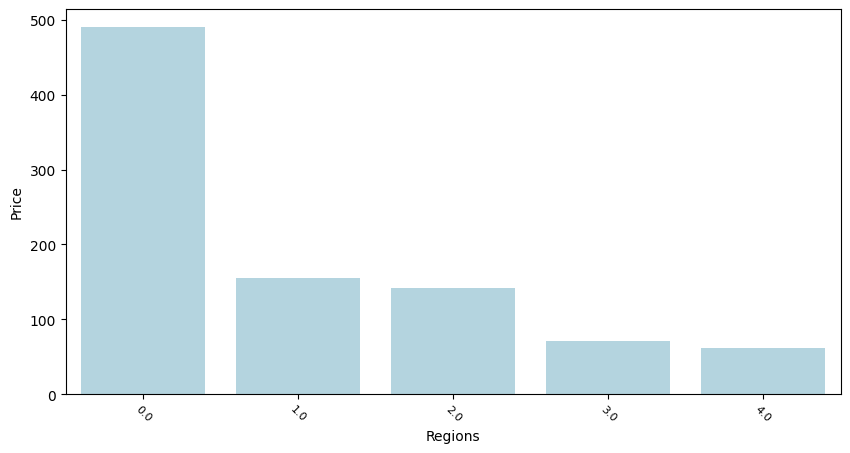

In [157]:
agg_lable_encoded_data = lable_encoded_data.groupby("Regions").count().reset_index()

fig5 = plt.subplots(figsize=(10,5))
fig5 = sns.barplot(x=agg_lable_encoded_data.iloc[:,0], y=agg_lable_encoded_data.iloc[:,1], order=agg_lable_encoded_data.sort_values(by="Price", ascending=False).iloc[:,0], color="lightblue")
fig5.set_xticklabels(labels=agg_lable_encoded_data.iloc[:,0],fontdict={"fontsize":"8","rotation":"-45"})
plt.show()


Again we take a look at the new regions projected on a map of Amsterdam

In [148]:
temp_for_plot = binned_data.copy()
for i in new_regions[1:]:
    temp_for_plot.loc[temp_for_plot[i].isna() == False, i] = i
    temp_for_plot.loc[temp_for_plot[i].isna() == True, i] = ""
    if i != new_regions[1]:
        temp_for_plot[new_regions[1]] += temp_for_plot[i]
temp_for_plot["Price_Region"] = temp_for_plot[new_regions[1]]


temp_for_plot.drop_duplicates(subset="Region", inplace=True)
temp_for_plot.reset_index(inplace=True)
temp_for_plot.drop(columns={*new_regions[1:],"level_0"}, inplace=True)
temp_for_plot["Avg_Price"] = avg_data["Price"]


In [149]:
fig2 = px.choropleth_mapbox(
    temp_for_plot,
    locations=temp_for_plot["Region"],
    geojson=geodata,color=temp_for_plot["Price_Region"],
    zoom=9.7, 
    center = {"lat": 52.356157, "lon": 4.907736},
    color_continuous_scale="matter", 
    mapbox_style="carto-positron",
    hover_data=[temp_for_plot["Price_Region"],temp_for_plot["Avg_Price"]],
    range_color=[temp_for_plot["Price_Region"].min(),temp_for_plot["Price_Region"].max()],
    width=1000,
    height=500
)

fig2.update_layout(                      
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig2.show()

NameError: name 'geodata' is not defined

Now we prepare the data by splitting with stratifying (Regions) and normal scaling.<br>
<br>
We will use a simple SGD Regression as well as three types of decision trees (Random Forest, AdaBoosted and XGBoosted).<br>
<br>
Finally we will create an assemble with all 4 the get our final predictions. We will estimate the performance of the estimation with the R2 and MSE values. To have a more intuitive understanding of the error we will also look at the MAE

In [32]:
rseed = random.seed(10)
X_train, x_test, Y_train, y_test = train_test_split(lable_encoded_data[["Area","Room","Regions"]], lable_encoded_data["Price"], test_size=0.2, train_size=0.8, random_state=rseed, shuffle=True, stratify=temp["Regions"])

In [33]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)


In [34]:
param_grid_SGD = {"loss" : ["squared_error"],
              "alpha" : [0.0001, 0.001, 0.01, 0.1, 0.2],
              "penalty" : ["l2", "l1", "elasticnet", "none"],
              "eta0" : [0.0001,0.001,0.01,0.1, 0.2, 0.3, 0.4, 0.5]
             }


model_SGD = GridSearchCV(SGDRegressor(random_state=rseed), param_grid_SGD ,cv=20, verbose=1, n_jobs=-1)

model_SGD.fit(X_train_scaled,Y_train)
#print(model_SGD.best_estimator_)


y_pred = model_SGD.predict(x_test_scaled)

print("R2: ", r2_score(y_test,y_pred))
print("MSE: ", mean_squared_error(y_test,y_pred))
print("MAE: ", mean_absolute_error(y_test,y_pred))

Fitting 20 folds for each of 160 candidates, totalling 3200 fits
R2:  0.629758425450671
MSE:  90328497004.4439
MAE:  121184.09171710834


In [35]:
param_grid_RanFor = {"criterion" : ["squared_error","absolute_error"],
              "min_samples_split" : [2,3,4,5,6],
              "min_samples_leaf" : [2,3,4,5,6],
              "min_impurity_decrease" : [0,0.01,0.25,0.5]
             }

model_RanFor = GridSearchCV(RandomForestRegressor(random_state=rseed), param_grid_RanFor, cv=20, verbose = 1, n_jobs=-1)

model_RanFor.fit(X_train_scaled,Y_train)
#print(model_RanFor.best_estimator_)


y_pred = model_RanFor.predict(x_test_scaled)

print("R2: ", r2_score(y_test,y_pred))
print("MSE: ", mean_squared_error(y_test,y_pred))
print("MAE: ", mean_absolute_error(y_test,y_pred))

Fitting 20 folds for each of 200 candidates, totalling 4000 fits
R2:  0.8858006253889817
MSE:  27861425016.94215
MAE:  79355.644375


In [36]:
param_grid_Ada = {"loss" : ["linear","square", "exponential"],
              "n_estimators" : [50,100,500,1000],
              "learning_rate" : [0.1,0.01,0.001,0.0001]
             }

model_Ada = GridSearchCV(AdaBoostRegressor(random_state=rseed, base_estimator=None), param_grid_Ada, cv=20, verbose=1, n_jobs=-1)

model_Ada.fit(X_train_scaled,Y_train)
#print(model_Ada.best_estimator_)


y_pred = model_Ada.predict(x_test_scaled)

print("R2: ", r2_score(y_test,y_pred))
print("MSE: ", mean_squared_error(y_test,y_pred))
print("MAE: ", mean_absolute_error(y_test,y_pred))

Fitting 20 folds for each of 48 candidates, totalling 960 fits
R2:  0.9215318563737359
MSE:  19144012892.43899
MAE:  81657.83903179792


In [37]:
param_grid_XGB = {"n_estimators" : [500,750,1000,2000,5000],
              "learning_rate" : [0.01,0.001,0.0001],
              "max_depth" : [1,2,3,4],
              "booster" : ["gbtree", "gblinear"]
             }


model_XGB = GridSearchCV(xgb.XGBRegressor(random_state=rseed), param_grid_XGB, cv=20, verbose=1, n_jobs=-1)
model_XGB.fit(X_train_scaled,Y_train)
#print(model_XGB.best_estimator_)


y_pred = model_XGB.predict(x_test_scaled)

print("R2: ", r2_score(y_test,y_pred))
print("MSE: ", mean_squared_error(y_test,y_pred))
print("MAE: ", mean_absolute_error(y_test,y_pred))

Fitting 20 folds for each of 120 candidates, totalling 2400 fits
[16:24:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2:  0.8095392458798008
MSE:  46467049733.54734
MAE:  132193.22503396738


In [38]:
model_Vote = VotingRegressor([('model_SGF', model_SGD), ('model_RanFor', model_RanFor), ('model_Ada', model_Ada), ('model_XGB', model_XGB)])
model_Vote.fit(X_train_scaled,Y_train)


y_pred = model_Vote.predict(x_test_scaled)

print("R2: ", r2_score(y_test,y_pred))
print("MSE: ", mean_squared_error(y_test,y_pred))
print("MAE: ", mean_absolute_error(y_test,y_pred))

Fitting 20 folds for each of 160 candidates, totalling 3200 fits
Fitting 20 folds for each of 200 candidates, totalling 4000 fits
Fitting 20 folds for each of 48 candidates, totalling 960 fits
Fitting 20 folds for each of 120 candidates, totalling 2400 fits
[16:26:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


R2:  0.9145244648692132
MSE:  20853618690.479664
MAE:  90237.80559364708


#### <b>Final Thoughts</b>
We have seen that the features of the data set, although few, are good estimator for the house price. However, the imbalance of the data set (specifically of the categorical feature) is a critical issue that should be stressed in a real scenario. Since the data set is so small we have not much wiggle room to combat this issue.<br>
The performance of the models are not the worst. However, it is unlikely that somebody in real life would be happy with a error margin of about 100000. Additionally, although we use a grid search that includes a K-fold of 20 the performance might vary after every training. We are in the same situation when looking at the data splitting. The representation of the data might highly vary from one split to the next. To combat this we could go on and create and train different sets of splits however for the purpose of this notebook and the low potential gain we conclude this exercise at this point